In [3]:
import os, pandas as pd, numpy as np
import matplotlib.pyplot as plt

#PATH = '/kaggle/input/novozyme-submission-files/'
PATH= '../../NOVO/submission/'
files = os.listdir(PATH)
print(f'We have {len(files)} features/models.')

We have 41 features/models.


In [4]:
df= pd.read_csv("../../NOVO/train.csv")


print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31390 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            31390 non-null  int64  
 1   protein_sequence  31390 non-null  object 
 2   pH                31104 non-null  float64
 3   data_source       28043 non-null  object 
 4   tm                31390 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB
None
             seq_id            pH            tm
count  31390.000000  31104.000000  31390.000000
mean   15694.500000      6.892339     49.147337
std     9061.656811      1.612225     14.010089
min        0.000000      1.990000     -1.000000
25%     7847.250000      7.000000     42.100000
50%    15694.500000      7.000000     48.000000
75%    23541.750000      7.000000     53.800000
max    31389.000000     64.900000    130.000000


In [5]:
# CREATE NUMPY TRAIN ARRAY WITH FEATURES/MODELS
x_train = []
for f in files:
    df = pd.read_csv(PATH+f)
    x_train.append(df.tm.values)
x_train = np.stack(x_train).T
x_train.shape

(2413, 41)

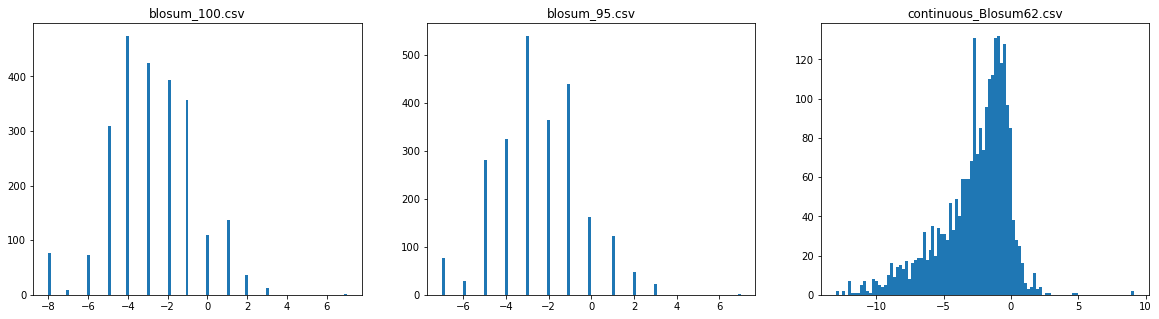

In [6]:
# DISPLAY SOME FEATURES/MODELS
for j in range(1):
    plt.figure(figsize=(20,5))
    for k in range(3):
        plt.subplot(1,3,k+1)
        plt.hist(x_train[:,k+3*j],bins=100)
        plt.title(files[k+3*j])
    plt.show()

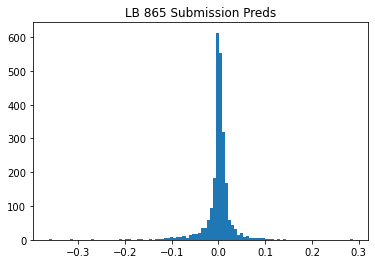

In [7]:
from scipy.stats import spearmanr

# LOAD TARGETS
PATH2 = '../../NOVO/submission2/'
y_train = pd.read_csv(PATH2 + 'Novozyme_Public_LB_865.csv').tm.values
plt.title('LB 865 Submission Preds')
plt.hist(y_train,bins=100)
plt.show()

In [8]:
# LOCATE THE PUBLIC LB
mask = np.array( [False]*len(y_train) )
mask[:541] = True
mask[-656:] = True

# REMOVE DELETE MUTATIONS
test = pd.read_csv('../../NOVO/test.csv')
delete = test.loc[test.protein_sequence.str.len()<221].index.values
mask[delete] = False

# OBJECTIVE FUCTION - SPEARMAN CORRELATION
slope,intercept = (858.3108981818078, -0.09320121696697797)
def compute_metric(p, apply_mask=True):
    true = y_train[mask]
    if apply_mask: pred = p[mask]
    else: pred = p
    r = spearmanr( true,pred ).correlation
    return slope * r + intercept

In [9]:
from scipy.stats import rankdata

NORMALIZE = False
RANK = True

for k,name in enumerate(files):
    if RANK:
        x_train[:,k] = rankdata( x_train[:,k] )
    if NORMALIZE:
        p = x_train[:,k]
        mn = np.mean(p)
        sd = np.std(p)
        x_train[:,k] = (p-mn)/sd

In [10]:
best_score = 0
best_index = -1

for k,name in enumerate( files ):
    s = compute_metric(x_train[:,k])
    if s > best_score:
        best_score = s
        best_index = k
    print(f'Spearman {s:0.1f} {name}') 
print()
print(f'Best single model is {files[best_index]} with Spearman = {best_score:0.1f}')

Spearman 193.5 blosum_100.csv
Spearman 197.9 blosum_95.csv
Spearman 300.1 continuous_Blosum62.csv
Spearman 190.1 ddgun_3d.csv
Spearman 270.7 ddgun_seq.csv
Spearman 362.9 deepDDG.csv
Spearman 285.0 DeMask_entropy.csv
Spearman 313.2 DeMask_log2f_var.csv
Spearman 370.5 DeMask_score.csv
Spearman 236.5 DeMask_sub_matrix.csv
Spearman 294.2 duet.csv
Spearman 223.3 dynamut.csv
Spearman 237.5 ESM.csv
Spearman 232.2 ESM_entropy.csv
Spearman 303.3 ESM_finetune.csv
Spearman 210.9 ESM_mut_prob.csv
Spearman 381.5 gemme.csv
Spearman 239.1 imut_3d.csv
Spearman 215.7 imut_seq.csv
Spearman 293.3 inps_3d.csv
Spearman 244.5 inps_seq.csv
Spearman 211.4 mCSM.csv
Spearman 291.4 pLDDT.csv
Spearman 297.4 pLDDT_diff.csv
Spearman 451.8 RASP.csv
Spearman 323.5 residue_depth_mut.csv
Spearman 328.6 residue_depth_wt.csv
Spearman 407.5 RMSD.csv
Spearman 472.6 Rosetta_Energy.csv
Spearman 426.7 RSASA_mut.csv
Spearman 446.6 RSASA_wt.csv
Spearman 410.6 SASA_wt.csv
Spearman 420.0 SASA_wtmut.csv
Spearman 401.6 SA_apolar.cs

In [11]:
USE_NEGATIVE_WGT = True
MAX_MODELS = 1000
TOL = 1e-5

In [12]:
indices = [best_index]
old_best_score = best_score
best_ensemble = x_train[:,best_index]

models = [best_index]
weights = []
metrics = [best_score]

for kk in range(1_000_000):

    best_score = 0
    best_index = -1
    best_weight = 0

    for k,ff in enumerate(files):
        
        new_model = x_train[:,k]
        start = -0.50
        if not USE_NEGATIVE_WGT: start = 0.01
            
        for wgt in list(np.arange(start,0.51,0.01)): 
            tmp = (1-wgt) * best_ensemble + wgt * new_model
            s = compute_metric(tmp)
            if s > best_score:
                best_score = s
                best_index = k
                best_weight = wgt
                potential_ensemble = tmp
    
    indices.append(best_index)
    indices = list(np.unique(indices))

    if len(indices)>MAX_MODELS:
        print(f'=> We reached {MAX_MODELS} models')
        indices = indices[:-1]
        break
    
    if best_score - old_best_score < TOL: 
        print(f'=> We reached tolerance {TOL}')
        break
        
    print(kk,'New best spearman',best_score,'adding',files[best_index],'with weight',f'{best_weight:0.3f}')
        
    models.append(best_index)
    weights.append(best_weight)
    metrics.append(best_score)
    best_ensemble = potential_ensemble
    old_best_score = best_score

0 New best spearman 563.7795354217142 adding Rosetta_Energy.csv with weight 0.470
1 New best spearman 592.4401680506191 adding RMSD.csv with weight 0.250
2 New best spearman 606.1085107991611 adding pLDDT_diff.csv with weight 0.150
3 New best spearman 616.1262833374404 adding DeMask_log2f_var.csv with weight 0.150
4 New best spearman 619.7535032901272 adding DeMask_entropy.csv with weight -0.080
5 New best spearman 622.7150472464078 adding Thermonet_v1.csv with weight -0.090
6 New best spearman 624.8660543308464 adding ESM_entropy.csv with weight 0.050
7 New best spearman 627.098212914906 adding ESM.csv with weight -0.060
8 New best spearman 628.3745142301724 adding RASP.csv with weight 0.060
9 New best spearman 629.591268121635 adding gemme.csv with weight 0.060
10 New best spearman 631.6453292955088 adding XGB_v1.csv with weight -0.080
11 New best spearman 633.1108943937855 adding RSASA_wt.csv with weight 0.070
12 New best spearman 634.5944464770942 adding SASA_wt.csv with weight -0.

In [13]:
wgt = np.array([1])
for w in weights:
    wgt = wgt*(1-w)
    wgt = np.concatenate([wgt,np.array([w])])
    
rows = []
t = 0
for m,w,s in zip(models,wgt,metrics):
    name = files[m]
    dd = {}
    dd['weight'] = w
    dd['model'] = name
    rows.append(dd)
    t += float( f'{w:.3f}' )
    
df = pd.DataFrame(rows)
df = df.groupby('model').agg('sum').reset_index().sort_values('weight',ascending=False)
df = df.reset_index(drop=True)
df

,model,weight
0,Thermonet_v2.csv,0.340130
1,Rosetta_Energy.csv,0.239979
2,RMSD.csv,0.183993
3,RSASA_wt.csv,0.182985
4,pLDDT_diff.csv,0.151001
5,DeMask_log2f_var.csv,0.138595
6,sdm.csv,0.111450
7,gemme.csv,0.077837
8,RASP.csv,0.063770
9,ESM_entropy.csv,0.052950


In [14]:
print('Ensemble weights sum to',df.weight.sum())
df.to_csv('ensemble_weights.csv',index=False)

Ensemble weights sum to 0.9999999999999996


In [15]:
x_map = {x:y for x,y in zip(files,np.arange(len(files)))}
pred = x_train[:, x_map[df.model.iloc[0]] ] * df.weight.iloc[0]
for k in range(1,len(df)):
    pred += x_train[:, x_map[df.model.iloc[k]] ] * df.weight.iloc[k]
m = compute_metric(pred)
print(f'Ensemble has spearman {m:0.1f}')

Ensemble has spearman 642.6


In [16]:
sub = pd.read_csv(PATH+files[1])
sub.tm = pred
sub.to_csv('submission_hill_climb.csv',index=False)
sub.head()

,seq_id,tm
0,31390,2086.786572
1,31391,2037.272191
2,31392,1668.087668
3,31393,1325.432139
4,31394,1312.091663


In [17]:
public_test = x_train[mask,]
public_target = y_train[mask]
public_test.shape

(1162, 41)

In [18]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=4,n_estimators=100,random_state=77)
model.fit( public_test, public_target )
p = model.predict( public_test )
m = compute_metric(p, apply_mask=False)
print('Our train metric is spearman',m)

Our train metric is spearman 650.9324759124818


In [19]:
pred = model.predict(x_train)
pred.shape

(2413,)

In [20]:
sub = pd.read_csv(PATH+files[1])
sub.tm = pred
sub.to_csv('submission_random_forest.csv',index=False)
sub.head()

,seq_id,tm
0,31390,0.029214
1,31391,0.028585
2,31392,0.007427
3,31393,0.005132
4,31394,0.004671


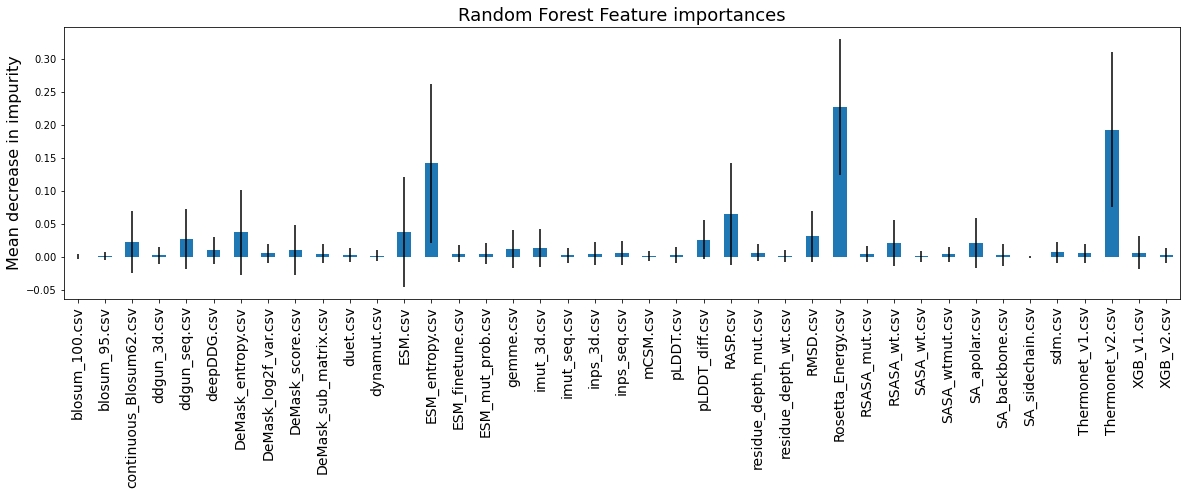

In [21]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=files)
plt.figure(figsize=(20,5))
forest_importances.plot.bar(yerr=std)
plt.title("Random Forest Feature importances",size=18)
plt.ylabel("Mean decrease in impurity",size=16)
plt.xticks(fontsize=14, rotation=90)
plt.show()

In [22]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

### Random Forest Tree 1


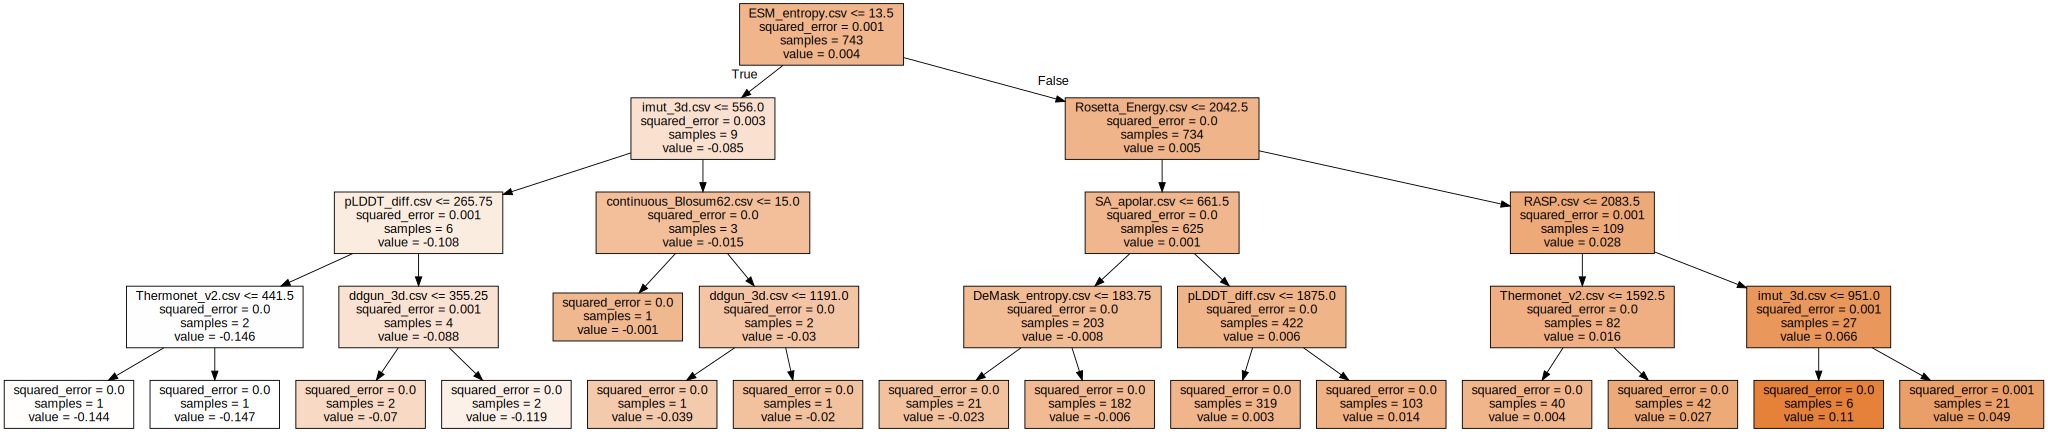





### Random Forest Tree 2


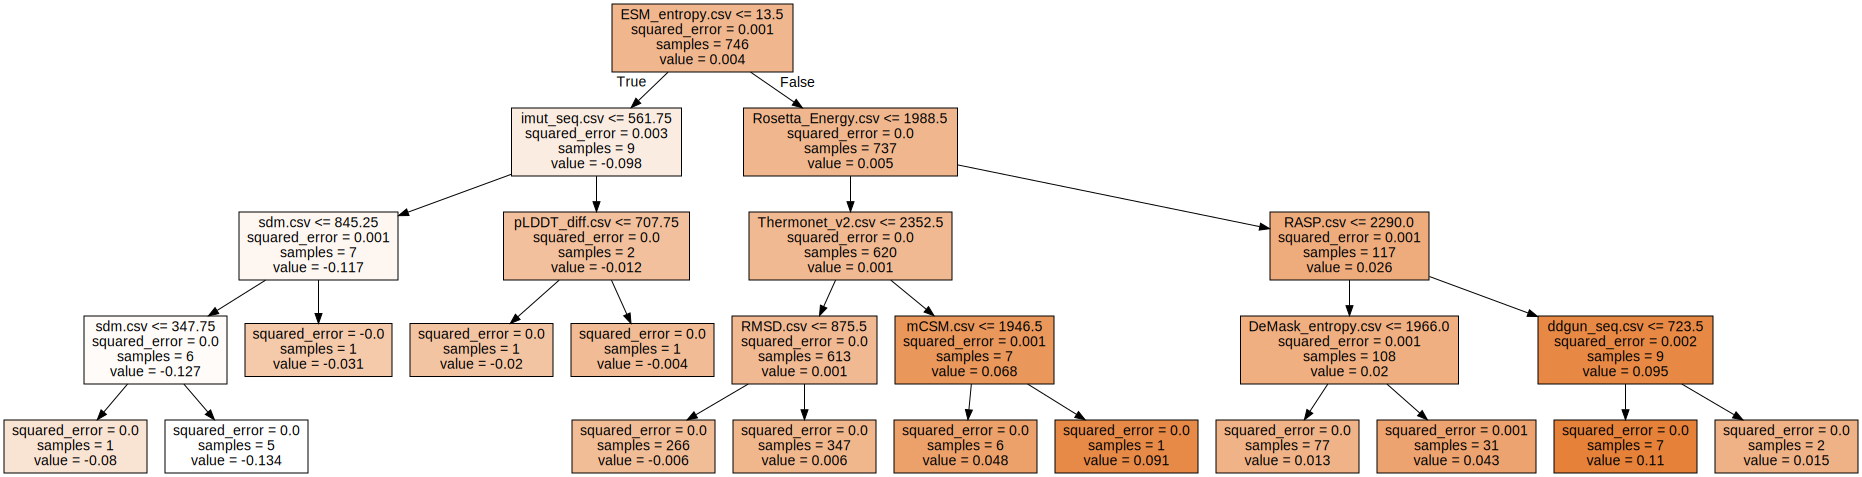





### Random Forest Tree 3


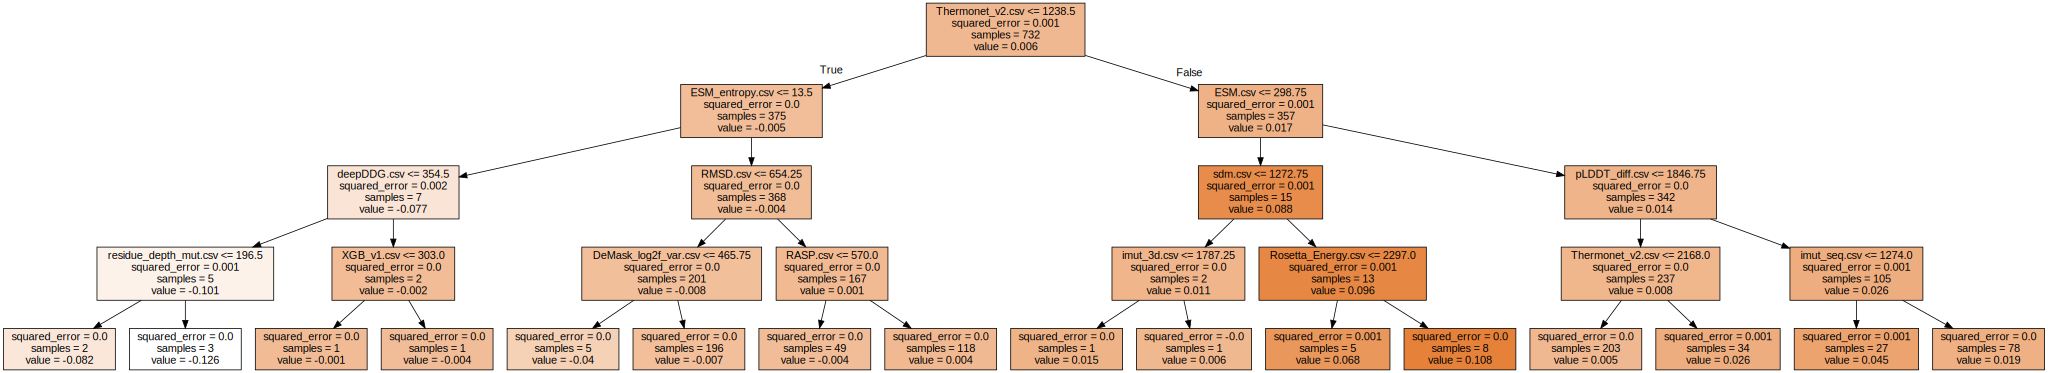





### Random Forest Tree 4


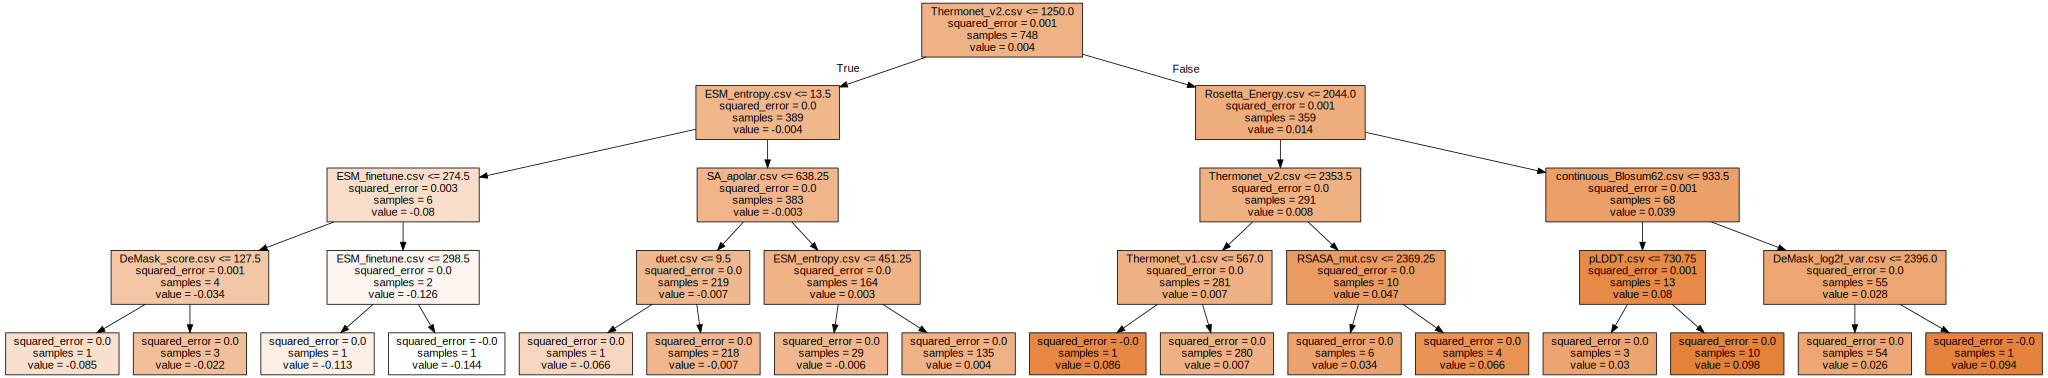

In [25]:
from sklearn import tree
import graphviz

for k in range(4):
    print('### Random Forest Tree',k+1)
    
    clf = model.estimators_[k]
    dot_data = tree.export_graphviz(clf, out_file=None, 
                                    feature_names=files,  
                                    filled=True)

    # Draw graph
    graph = graphviz.Source(dot_data, format="png")  
    display(graph)
    print('\n\n\n')

In [32]:
#graph.format = "png"
graph.render("tree")

'tree.png'